# Working with Beautifulsoup4

## Setup

In [1]:
import bs4

Let's say that we are interested in finding the price of my favorite Android Programming Guide on amazon. The page looks like this with the price in red just above the big "Buy now..." button

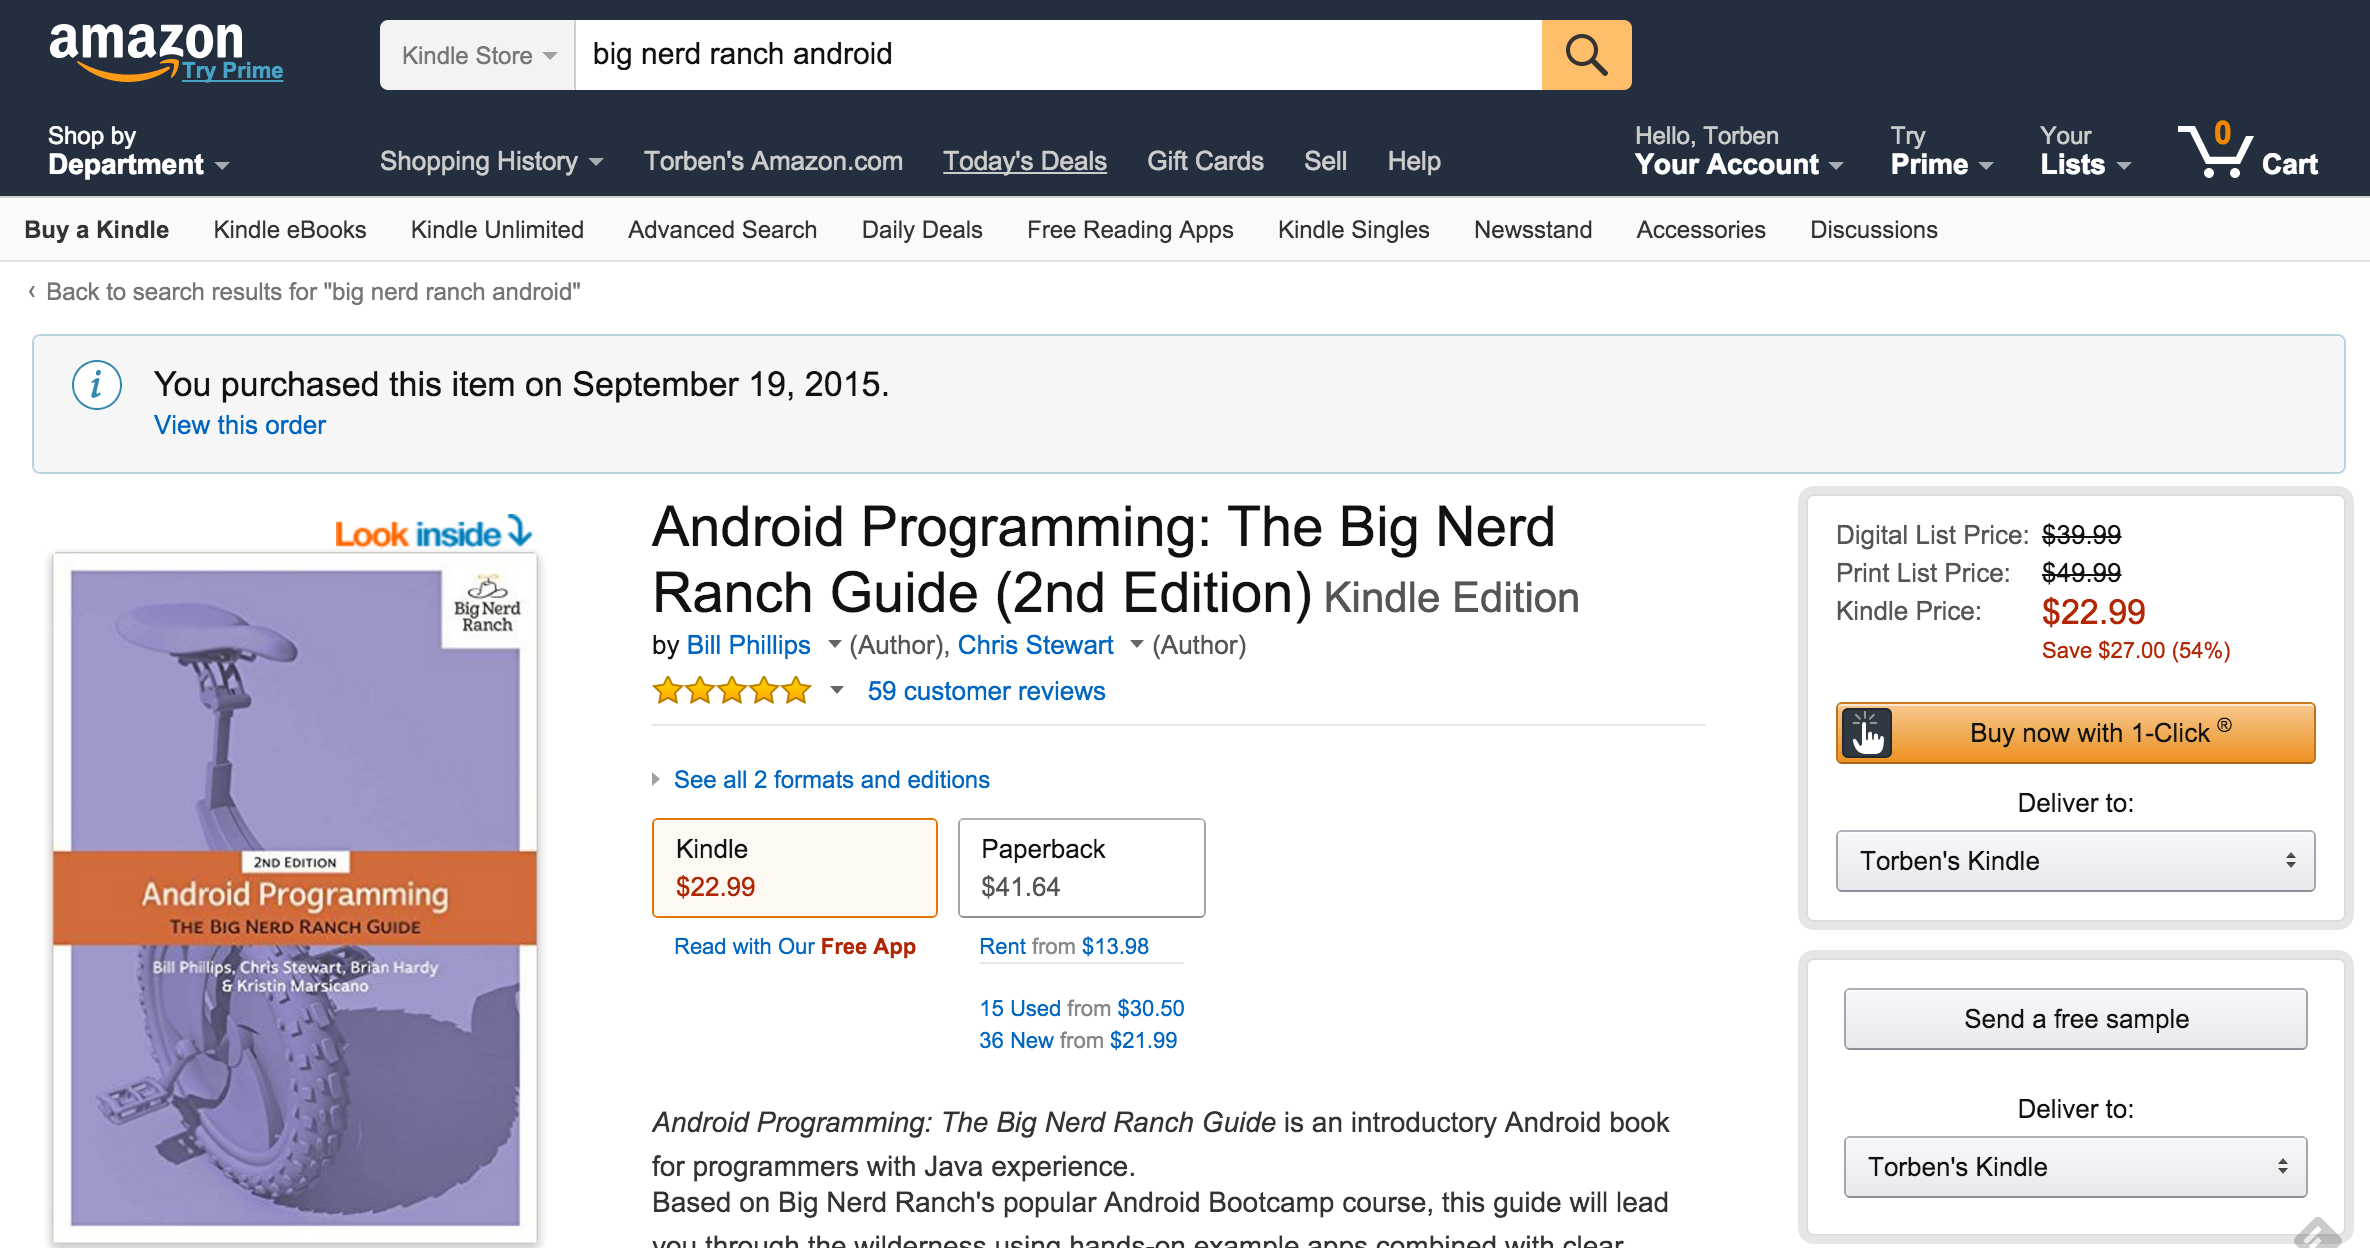

In [2]:
from IPython.display import Image
Image(filename='images/amazon.png') 

In [41]:
import bs4
import requests
response = requests.get('http://www.amazon.com/Android-Programming-Nerd-Ranch-Guide-ebook/dp/B0136ZXIMM/')
response.raise_for_status()

In [42]:
soup = bs4.BeautifulSoup(response.text, 'html.parser')

## Working with CSS Selectors
The page is now parsed and ready for us to navigate and filter. One way of doing this is using CSS selectors and a really fast way to get this for the price we are interested in is to right click the price one the page and select "Inspect" in the Chrome pop up menu.

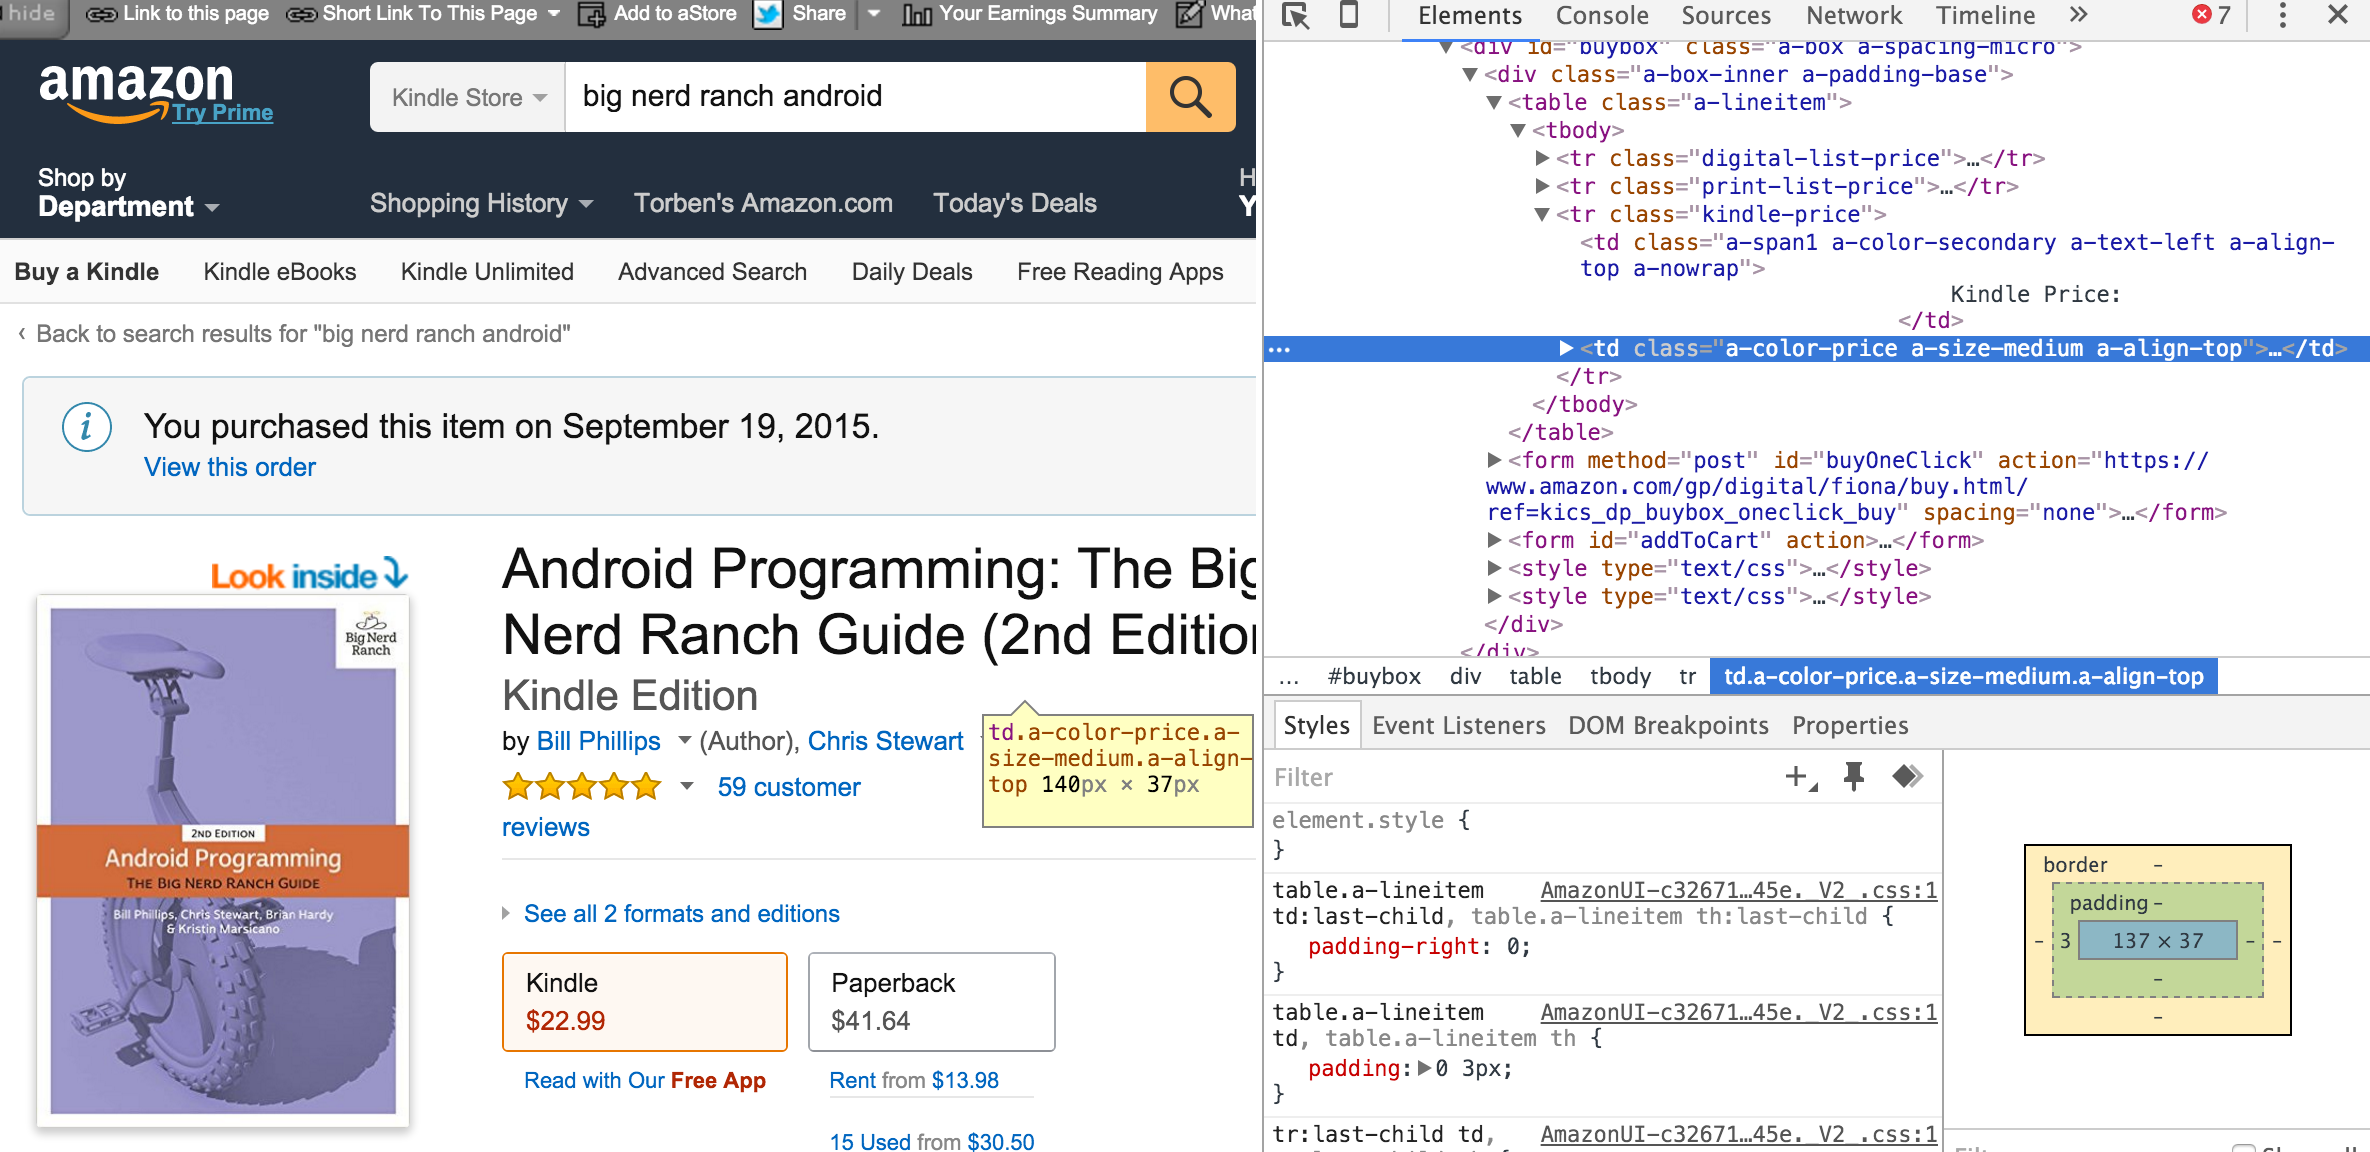

In [6]:
from IPython.display import Image
Image(filename='images/amazon inspect.png') 

### Copy the selector
The line in the html code containing the price is now hightlighted. When you then right click this line again, and select "copy selector", you will not have to figure anything out on your own. This is what I got:

```
#buybox > div > table > tbody > tr.kindle-price > td.a-color-price.a-size-medium.a-align-top
```
Pasting all this into the `soup.select()` statement returned nothing, but peeling off a bit of the high level ended up giving me something I could use

In [43]:
soup.select('tr.kindle-price > td.a-color-price.a-size-medium.a-align-top')

[<td class="a-color-price a-size-medium a-align-top">\n                            $22.99\n                            \n                            \n                                <p class="a-size-mini a-color-price ebooks-price-savings a-text-normal">\n                                    Save $27.00 (54%)\n                                </p>\n</td>]

In [44]:
tfield=soup.select('td.a-color-price.a-size-medium.a-align-top')[0]

In [45]:
tfield.text

u'\n                            $22.99\n                            \n                            \n                                \n                                    Save $27.00 (54%)\n                                \n'

In [46]:
tfield.text.strip()

u'$22.99\n                            \n                            \n                                \n                                    Save $27.00 (54%)'

In [47]:
tfield.text.strip().split('\n')[0]

u'$22.99'

## Creating a function

In [48]:
def AmazonPrice(url):
    response = requests.get(url)
    response.raise_for_status()  
    
    elems=bs4.BeautifulSoup(response.text, 'html.parser')
    tfield=elems.select('td.a-color-price.a-size-medium.a-align-top')[0].text
    return tfield.strip().split('\n')[0]

print AmazonPrice('http://www.amazon.com/Android-Programming-Nerd-Ranch-Guide-ebook/dp/B0136ZXIMM/')

$22.99


# Example: Download xkcd comics
Here is how to fech the last set of xkcd cartoons and load them in the notebook

In [97]:
import requests, os, bs4
LIMIT=5

url = 'http://xkcd.com'  
fetched=0
names=[]
while not url.endswith('#') and (fetched<LIMIT):
    print('Downloading page %s...' % url)
    res = requests.get(url)
    res.raise_for_status()

    soup = bs4.BeautifulSoup(res.text)

    # Find the URL of the comic image.
    comicElem = soup.select('#comic img')
    if comicElem == []:
        print('Could not find comic image.')
    else:
        try:
            comicUrl = 'http:' + comicElem[0].get('src')
            print('Downloading image %s...' % (comicUrl))
            # Download the image.
            res = requests.get(comicUrl)
            res.raise_for_status()
        except requests.exceptions.MissingSchema:
            # skip this comic
            prevLink = soup.select('a[rel="prev"]')[0]
            url = 'http://xkcd.com' + prevLink.get('href')
            continue

        # Save the image to ./xkcd.
        imageFile = open(os.path.join('images/xkcd', os.path.basename(comicUrl)), 'wb')
        for chunk in res.iter_content(100000):
            imageFile.write(chunk)
        imageFile.close()
        names.append((imageFile.name, comicElem[0].attrs['title'] ))

    # Get the Prev button's url.
    prevLink = soup.select('a[rel="prev"]')[0]
    url = 'http://xkcd.com' + prevLink.get('href')
    fetched+=1


print('Done.')


Done.


In [96]:
comic=soup.select('#comic img')[0]
comic.attrs['title']

u'SOUND DOGS MAKE: [BARKING] [HISSING] [LIGHTSABER NOISES] [FLUENT ENGLISH] [SWEARING]'

In [98]:
names

[(u'images/xkcd/2016.png', u'Want to feel old? Wait.'),
 (u'images/xkcd/2016_conversation_guide.png',
  u"The real loser in an argument about the meaning of the word 'hoverboard' is anyone who leaves that argument on foot."),
 (u'images/xkcd/henge.png',
  u"I've got the Craigslist post ready to go! I wasn't sure what category it should go in, so I listed it as property and put that it has 'good sun exposure.'"),
 (u'images/xkcd/fixion.png',
  u'My theory predicts that, at high enough energies, FRBs and perytons become indistinguishable because the detector burns out.'),
 (u'images/xkcd/christmas_settings.png',
  u'SOUND DOGS MAKE: [BARKING] [HISSING] [LIGHTSABER NOISES] [FLUENT ENGLISH] [SWEARING]')]

## Including all images in a cell

In [100]:
from IPython.display import HTML
from IPython.display import display
imagesList=''.join( ["<img src='%s' title='%s'/>" % (str(s),str(a)) for s,a in names ])
display(HTML(imagesList))

# More information
Detailed documentation is available [here](http://www.crummy.com/software/BeautifulSoup/bs4/doc/)